# Seasonal Autoregressive Integrated Moving Average
### Model for time series forecasting with data containing trends and/or seasonality

In [116]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

Reading in CDC hospitalization data

In [117]:
df_hospital = pd.read_csv('../data/hospital_visits.csv')
df_hospital['Week'] = df_hospital.Week.map(str) + "-" + df_hospital.Year.map(str)
df_hospital = df_hospital[['Total ILI']]
list_data = list(df_hospital['Total ILI'])

In [118]:
list_data = list(df_hospital['Total ILI'])

#### Defining the SARIMA model - forecasting the last 52 weeks
Optimal order and seasonal_order (found via hyperparameter tuning in sarima-script.py)

In [119]:
model = SARIMAX(list_data[:-52], order=(0, 1, 1), seasonal_order=(2, 1, 0, 52))
model_fit = model.fit(disp=False)

In [120]:
future = 52
predictions = model_fit.forecast(future)
future_weeks = list(range(len(list_data) - future - 1, len(list_data) + future - 1))

In [121]:
predictions_df = pd.DataFrame([future_weeks, predictions]).transpose()
predictions_df.columns = ['Week', 'Total ILI']
predictions_df = predictions_df.set_index('Week')

Text(0.5, 1.0, 'Total ILI: 2014-2015 to 2018-2019 + prediction')

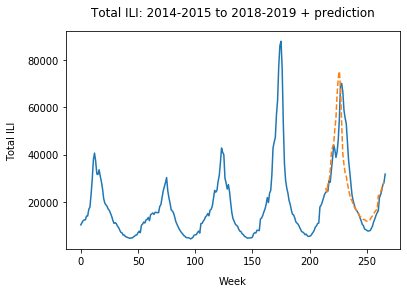

In [122]:
plt.plot(df_hospital['Total ILI'])
plt.plot(predictions_df, '--')
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI: 2014-2015 to 2018-2019 + prediction", pad=15)

In [123]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  215
Model:             SARIMAX(0, 1, 1)x(2, 1, 0, 52)   Log Likelihood               -1516.764
Date:                            Tue, 10 Dec 2019   AIC                           3041.528
Time:                                    23:27:29   BIC                           3053.879
Sample:                                         0   HQIC                          3046.543
                                            - 215                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4925      0.054      9.135      0.000       0.387       0.598
ar.S.L52      -0.3542      0.125     -2.825      0.005      -0.600      -0.108
ar.S.L104     -0.1650      0.108     -1.527      0.127      -0.377       0.047
sigma2      8.584e+06   4.85e+05     17.710      0.000    7.63e+06    9.53e+06
===================================================================================
Ljung-Box (Q):                       41.27   Jarque-Bera (JB):              1321.88
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               3.49   Skew:                            -1.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Defining the SARIMA model - forecasting the next 52 weeks
Optimal order and seasonal_order (found via hyperparameter tuning in sarima-script.py)

In [125]:
model = SARIMAX(list_data, order=(0, 1, 1), seasonal_order=(2, 1, 0, 52))
model_fit = model.fit(disp=False)

In [126]:
future = 52
predictions = model_fit.forecast(future)
future_weeks = list(range(len(list_data) - 1, len(list_data) + future))

In [127]:
predictions_df = pd.DataFrame([future_weeks, predictions]).transpose()
predictions_df.columns = ['Week', 'Total ILI']
predictions_df = predictions_df.set_index('Week')

Text(0.5, 1.0, 'Total ILI: 2014-2015 to 2018-2019 + predictions')

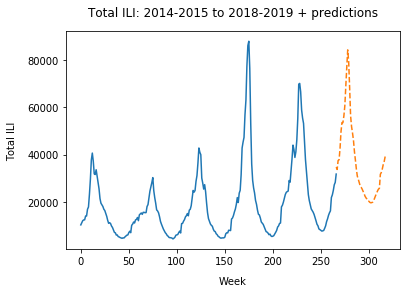

In [128]:
plt.plot(df_hospital['Total ILI'])
plt.plot(predictions_df, '--')
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI: 2014-2015 to 2018-2019 + predictions", pad=15)

In [129]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  267
Model:             SARIMAX(0, 1, 1)x(2, 1, 0, 52)   Log Likelihood               -1997.191
Date:                            Tue, 10 Dec 2019   AIC                           4002.382
Time:                                    23:33:30   BIC                           4015.846
Sample:                                         0   HQIC                          4007.822
                                            - 267                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5437      0.036     15.250      0.000       0.474       0.614
ar.S.L52      -0.6405      0.054    -11.754      0.000      -0.747      -0.534
ar.S.L104     -0.2373      0.074     -3.226      0.001      -0.381      -0.093
sigma2      7.236e+06   3.34e+05     21.638      0.000    6.58e+06    7.89e+06
===================================================================================
Ljung-Box (Q):                       57.07   Jarque-Bera (JB):              1195.06
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -1.06
Prob(H) (two-sided):                  1.00   Kurtosis:                        14.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predicting a previous year

In [130]:
model = SARIMAX(list_data[:-104], order=(0, 1, 1), seasonal_order=(2, 1, 0, 52))
model_fit = model.fit(disp=False)

In [131]:
future = 52
predictions = model_fit.forecast(future)
future_weeks = list(range(len(list_data) - 105, len(list_data) - future - 1))

In [132]:
predictions_df = pd.DataFrame([future_weeks, predictions]).transpose()
predictions_df.columns = ['Week', 'Total ILI']
predictions_df = predictions_df.set_index('Week')

Text(0.5, 1.0, 'Total ILI: 2014-2015 to 2018-2019 + predictions')

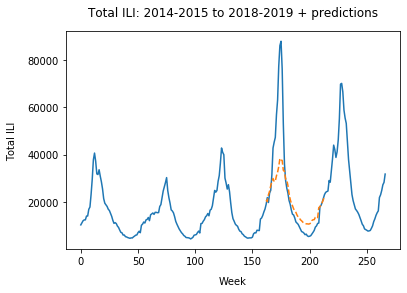

In [133]:
plt.plot(df_hospital['Total ILI'])
plt.plot(predictions_df, '--')
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI: 2014-2015 to 2018-2019 + predictions", pad=15)

In [134]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  163
Model:             SARIMAX(0, 1, 1)x(2, 1, 0, 52)   Log Likelihood                -993.434
Date:                            Tue, 10 Dec 2019   AIC                           1994.869
Time:                                    23:35:53   BIC                           2005.671
Sample:                                         0   HQIC                          1999.250
                                            - 163                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3343      0.081      4.112      0.000       0.175       0.494
ar.S.L52      -0.5260      0.143     -3.684      0.000      -0.806      -0.246
ar.S.L104     -0.1822      0.228     -0.799      0.424      -0.629       0.265
sigma2      3.945e+06   3.48e+05     11.329      0.000    3.26e+06    4.63e+06
===================================================================================
Ljung-Box (Q):                       35.60   Jarque-Bera (JB):               217.37
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.94
Prob(H) (two-sided):                  0.79   Kurtosis:                         9.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""